<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/2_Inicializacion_y_Regularizacion_de_NN_Solucionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASE 2: Inicializacion y Regularizacion de Neural Networks

En un problema de *regresion*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de *Clasificacion*, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir la eficiencia de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.


In [ ]:
# Use seaborn for pairplot
!pip install seaborn

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


### Obtenga la data
Primero descargue el set de datos.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

Importelo usando pandas.

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
dataset.Origin.unique()

array([1, 3, 2])

**Pregunta 1. ¿Cuántos registros y características inciales contiene el dataset?**

In [ ]:
#COMPLETAR
dataset.shape

(398, 8)

### Limpie la data

El set de datos contiene algunos valores desconocidos.

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**Pregunta 2. Interprete el reporte de missings anterior. Elija un método de imputación y resuelva el problema de missings.**

In [ ]:
#COMPLETAR
dataset.dropna(inplace=True)

La columna de `"Origin"` realmente es categorica, no numerica. Entonces conviertala a un "one-hot":

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Dividamos la data en entrenamiento y prueba

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspeccione la data

Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

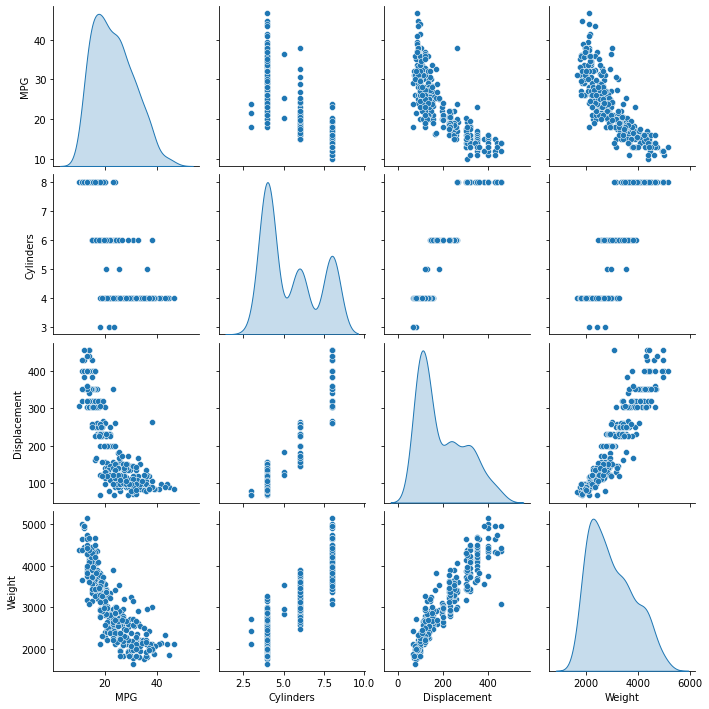

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

**Pregunta 3. Brevemente, interprete los resultados de la gráfica bivariada anterior. Sugerencia: enfóquese en el target.**

- Existe un grado de asociación entre la variable cylinders y MPG (El rango de valores de MPG disminuye mientras aumenta el valor de cylinders)
- Existe una correlación negativa no lineal entre las variables displacement y weight con MPG

Tambien revise las estadisticas generales:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separe las caracteristicas de las etiquetas.

Separe el valor objetivo, o la "etiqueta" 
de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalice la data

Revise otra vez el bloque de `train_stats` que se presento antes y note la diferencia de rangos de cada caracteristica.

Es una buena práctica normalizar los datos que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Estos datos normalizados es lo que usaremos para entrenar el modelo.

Precaución: las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, `build_model`, ya que crearemos un segundo modelo, más adelante.

In [ ]:
from tensorflow.python.keras.layers.core import Dropout
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

**Pregunta 4. ¿Qué inicializador usa layers.Dense por defecto y qué función de activación usa por defecto?**

Por defecto la inicialización que se emplea para las capas densas es el glorot_uniform y como activación no hay ninguna definida por defecto

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________



Ahora pruebe el modelo. Tome un lote de ejemplos `10` de los datos de entrenamiento y llame a` model.predict` en él.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.21998695],
       [ 0.0310153 ],
       [-0.07320622],
       [-0.3700173 ],
       [-0.45821822],
       [ 0.11033846],
       [-0.45840442],
       [ 0.61882406],
       [ 0.09752912],
       [-0.41479188]], dtype=float32)

Parece estar funcionando, y produce un resultado de la forma y tipo esperados.

### Entrenar el modelo

Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto `history`.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.559225,1.055372,2.559225,8.825678,2.328253,8.825678,995
996,2.226617,0.935861,2.226617,8.467481,2.264783,8.467481,996
997,2.459953,1.024926,2.459953,8.614357,2.319156,8.614357,997
998,2.832448,1.083628,2.832448,8.803994,2.290415,8.803994,998
999,2.327463,0.953033,2.327463,8.584416,2.307449,8.584416,999


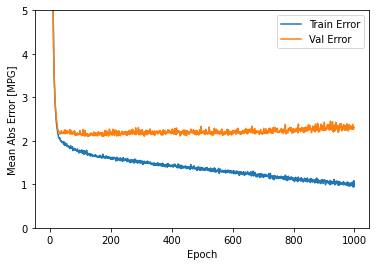

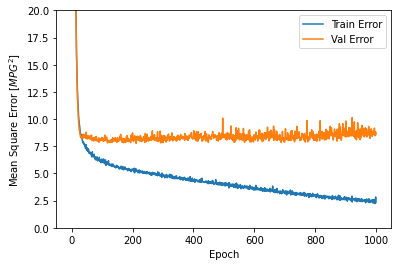

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada [Aca](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).


...................................................................................................

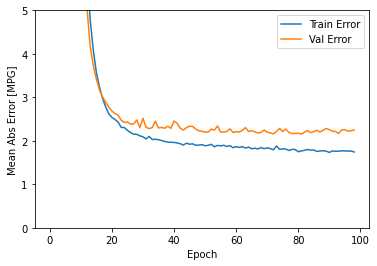

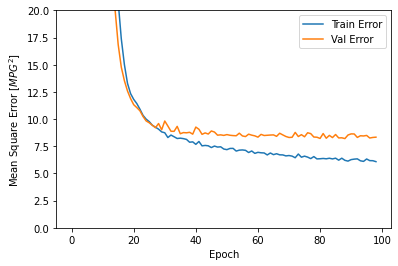

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? 

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7444 - mae: 1.8298 - mse: 5.7444 - 46ms/epoch - 15ms/step
Testing set Mean Abs Error:  1.83 MPG


### Haga Predicciones

Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas:

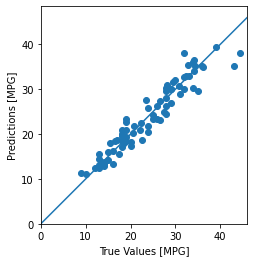

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

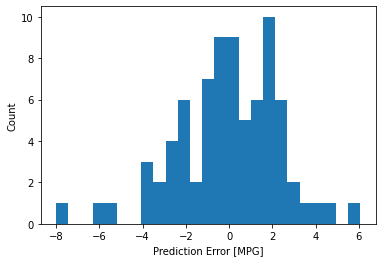

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

**Pregunta 5. Experimente utilizando He-initializer en cambio de Xavier en las capas densas. Imprima, interprete y compare sus learning curves y predicciones respecto al ejemplo base.**

In [ ]:
model_he = keras.Sequential([
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform', input_shape=[len(train_dataset.keys())]),
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model_he.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model_he.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_he = model_he.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, 
  verbose=1,
  callbacks=[early_stop]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                640       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 2s 56ms/step - loss: 545.0344 - mae: 21.8200 - mse: 545.0344 - val_loss: 510.1190 - val_mae: 20.8686 - val_mse: 510.1190
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 449.0075 - mae: 19.4446 - mse: 449.0075 - val_loss: 426.0450 - val_mae

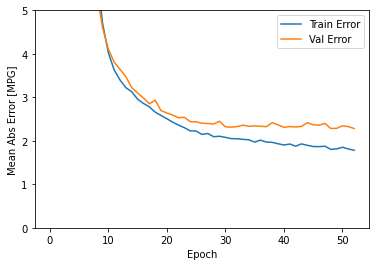

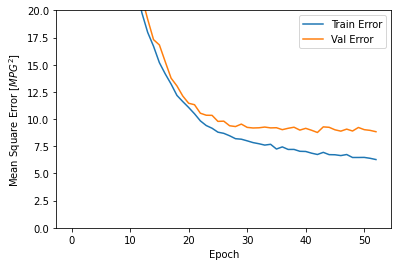

In [ ]:
plot_history(history_he)

**Pregunta 6. Experimente utilizando dropout (Probar con valores pequeños en el parámetro de rate). Imprima, interprete y compare sus learning curves y predicciones respecto al ejemplo base.**

In [ ]:
model_dropout = keras.Sequential([
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform', input_shape=[len(train_dataset.keys())]),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model_dropout.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model_dropout.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_dropout = model_dropout.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, 
  verbose=1,
  callbacks=[early_stop]
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                640       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 1s 34ms/step - loss: 519.8116 - mae: 21.4099 - mse: 519.8116 - val_loss: 458.2909 - val_mae: 19.8441 - val_mse: 458.2909
Epoch 2/100

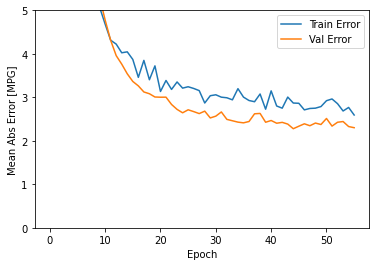

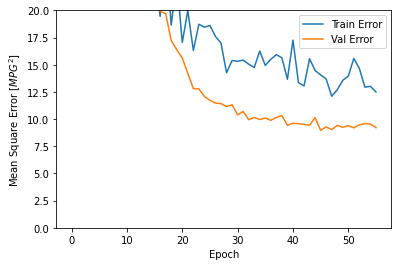

In [ ]:
plot_history(history_dropout)

**Pregunta 7. Experimente utilizando regularización sobre los pesos (sea l1 o l2). Imprima, interprete y compare sus learning curves y predicciones respecto al ejemplo base.**

In [ ]:
from keras import regularizers

In [ ]:
l2_r = regularizers.L2(l2 = 0.01)
model_l2 = keras.Sequential([
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = l2_r, input_shape=[len(train_dataset.keys())]),
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model_l2.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model_l2.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_l2 = model_l2.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, 
  verbose=1,
  callbacks=[early_stop]
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 2s 61ms/step - loss: 569.6261 - mae: 22.4215 - mse: 568.3246 - val_loss: 512.8658 - val_mae: 21.0808 - val_mse: 511.5605
Epoch 2/1000
8/8 [==============================] - 0s 14ms/step - loss: 464.7586 - mae: 19.9961 - mse: 463.4493 - val_loss: 422.8371 - val_mae

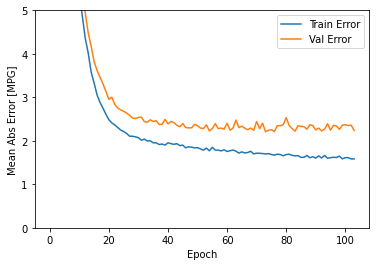

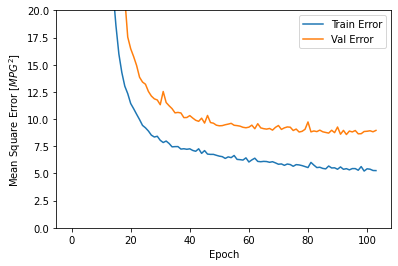

In [ ]:
plot_history(history_l2)

**Pregunta 8. Experimente combinando 2 conceptos tocados en clase. Imprima, interprete y compare sus learning curves y predicciones respecto al ejemplo base.**

In [ ]:
l2_r = regularizers.L2(l2 = 0.01)
model_mix = keras.Sequential([
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = l2_r, input_shape=[len(train_dataset.keys())]),
  layers.Dropout(0.2),
  layers.Dense(64, activation='relu', kernel_initializer = 'he_uniform'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model_mix.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model_mix.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_mix = model_mix.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, 
  verbose=1,
  callbacks=[early_stop]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                640       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
8/8 [==============================] - 1s 36ms/step - loss: 593.0433 - mae: 23.1757 - mse: 591.8044 - val_loss: 536.6788 - val_mae: 21.8767 - val_mse: 535.4382
Epoch 2/100

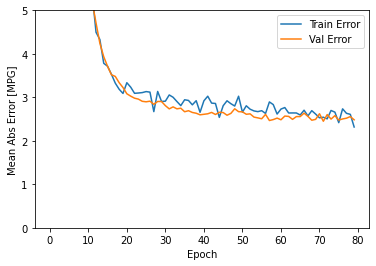

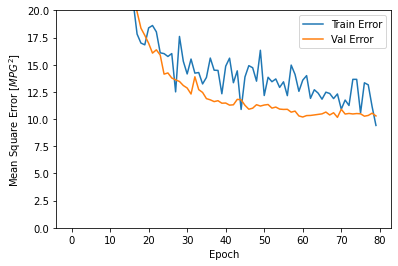

In [ ]:
plot_history(history_mix)